In [ ]:
%autosave 60

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
! pip install pandarallel
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from matplotlib import pyplot as plt
from tqdm.auto import tqdm, trange
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
tqdm.pandas()
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
def get_text_and_score(pathes):
    text_score = []
    for path in pathes:
        file_names = os.listdir(path)
        for file_name in file_names:
            with open(f'{path}/{file_name}', 'r') as file:
                text = file.read()
                score = int(file_name.split('.')[0].split('_')[-1])
            text_score.append([text, score])
    return text_score

In [ ]:
path = r'../data/aclImdb'
corpus = get_text_and_score([f'{path}/train/pos/', f'{path}/train/neg/', 
                             f'{path}/test/pos/', f'{path}/test/neg/'])


In [ ]:
dataset = pd.DataFrame(corpus, columns=('data', 'target'))

In [ ]:
dataset.isnull().sum()

In [ ]:
texts_count = 50000
dataset = dataset.iloc[:texts_count]

In [ ]:
dataset.dropna(inplace=True)

In [ ]:
text_lenth = dataset['data'].apply(len)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(text_lenth, 30, label='Гистограмма распределения длин текстов')
axs[1].boxplot(text_lenth, vert=False)

In [ ]:
def clean_regex(text):
    text = re.sub('\"{2,3}', '', text)
    text = re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    text = re.sub(r'[.,!?-]', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r' +', ' ', text)
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    
    return text

In [ ]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow.keras.utils import pad_sequences
from collections import Counter
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True, nb_workers = 8)

nltk.download('stopwords')
nltk.download('wordnet')
stopwords = [word for word in set(stopwords.words('english')) if word not in ('no', 'not')]

In [ ]:
max_lenth = 1000

In [ ]:
dataset

In [ ]:
rex_to_rem_stopwords = '|'.join(f'\s{word}\s' for word in stopwords)

In [ ]:
def tokenize_text(text):
    return word_tokenize(text)

def split_words_by_space(text):
    return text.split()

def make_lower(word_list):
    return list(map(lambda t: t.lower(), word_list))

def lemmatize(word_list):
    return list(map(lemmatizer.lemmatize, word_list))

def remove_stop_words1(word_list):
    text = join_word_list(word_list)
    text = re.sub(rex_to_rem_stopwords, ' ', text)
    return split_words_by_space(text)


def add_bos_tag(word_list):
    word_list.insert(0, '<bos>')
    return word_list

def limit_sequence(word_list, max_lenth):
    return word_list[:max_lenth]

def join_word_list(word_list):
    return ' '.join(word_list)

def preprocess_text(text):
    word_list = tokenize_text(text)
    lower_word_list = make_lower(word_list)
    lemmatized_word_list = make_lower(lower_word_list)
    word_list_with_bos = add_bos_tag(remove_stop_words1(lemmatized_word_list))
    preprocessed_text = join_word_list(limit_sequence(word_list_with_bos, 1000))
    
    return preprocessed_text

In [ ]:
threshold_count = 15
count_words = Counter(nltk.flatten(list(dataset['data'].parallel_apply(clean_regex).parallel_apply(tokenize_text).parallel_apply(make_lower))))

stopwords = set(stopwords)
for word in count_words:
    count = count_words[word]
    if count <= threshold_count:
        stopwords.add(word)
        
stopwords = sorted(list(stopwords))
vocabulary = [word for word in count_words if count_words[word] > threshold_count and word not in stopwords]

In [ ]:
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
# %script false
lemmatizer = WordNetLemmatizer()
dataset['cleaned text'] = dataset['data'].parallel_apply(clean_regex)
dataset['preprocessed text'] = dataset['cleaned text'].parallel_apply(preprocess_text)
dataset['preprocessed text']

In [ ]:
# text_lenth = dataset['preprocessed text'].parallel_apply(len)

In [ ]:
dataset

In [ ]:
# %%script false
# dataset.to_csv('processed_data.csv')

In [ ]:
dataset = pd.read_csv('../data/processed_data copy.csv')

In [ ]:
print(dataset.head())

In [ ]:
def get_vocabulary(data_column):
    word_list_column = list(data_column.parallel_apply(split_words_by_space))
    vocabulary = sorted(list(set(nltk.flatten(word_list_column))))
    return vocabulary

In [ ]:
vocabulary = get_vocabulary(dataset['preprocessed text'])

In [ ]:
def word2int(vocabulary):
    word2int_dict = {word : i for i, word in enumerate(vocabulary, 1)}
    int2word_dict = {i : word for word, i in word2int_dict.items()}
    return (word2int_dict, int2word_dict)
        
word2int_dict, int2word_dict = word2int(vocabulary)

In [ ]:
vocabulary

In [ ]:
def encode_sequence(sequence):
    sequence = split_words_by_space(sequence)
    return [word2int_dict[word] for word in sequence]

dataset['encoded sequences'] = dataset['preprocessed text'].parallel_apply(encode_sequence)
dataset['encoded sequences']

In [ ]:
maxlen = max(text_lenth)
dataset['padded sequences'] = list(pad_sequences(dataset['encoded sequences'], max_lenth, padding='pre', value=0))
dataset['padded sequences']

In [ ]:
dataset

In [ ]:
one_hot_vector_lenth = len(vocabulary) + 1
# one_hot_vector_lenth

In [ ]:
def get_one_hot_vector_by_index(index, lenth):
    vector = np.zeros((lenth))
    vector[index] = 1
    return vector

def get_one_hot_vector_by_word(word, lenth):
    index = word2int_dict[word]
    return get_one_hot_vector_by_index(index, lenth)

def get_index_by_one_hot_vector(vector):
    return np.argmax(vector)

def get_word_by_index_one_hot(index):
    return int2word_dict[index]

def encode_secquence_one_hot(sequence):
    return np.array(list(map(lambda a: get_one_hot_vector_by_index(a, one_hot_vector_lenth), sequence)))

In [ ]:
# dataset['one hot'] = dataset['padded sequences'].parallel_apply(encode_secquence_one_hot)
# dataset['one hot']

# WORD2VEC

In [ ]:
! pip install torch gensim scikit-learn

In [ ]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
corpus = dataset['encoded sequences']

In [ ]:
corpus

In [ ]:
embed_dim = 300
w2v_model = Word2Vec(sentences=corpus, vector_size=embed_dim, window=3, min_count=0, workers=4)

In [ ]:
w2v_matrix = np.zeros((one_hot_vector_lenth, embed_dim))
for index, word in enumerate(sorted(w2v_model.wv.index_to_key), 1):
    vec = torch.FloatTensor(w2v_model.wv.get_vector(word)).view((embed_dim))

    w2v_matrix[index] = vec

In [ ]:
def split_data(data, labels, test_size=0.2, random_state=None):
    train_data, test_data, train_labels, test_labels = train_test_split(
        data, labels, test_size=test_size, random_state=random_state
    )
    return train_data, test_data, train_labels, test_labels


In [ ]:
class TextDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        text = self.data[index]
        label = self.labels[index]
        return torch.tensor(text), torch.tensor(label)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
df = dataset.sample(frac=1)

In [ ]:
data = np.array(df['padded sequences'])
labels = np.array(df['target'] > 5).astype(int)

train_data, test_data, train_labels, test_labels = split_data(data[:], labels[:], test_size=0.2, random_state=42)

In [493]:
batch_size = 64
hidden_dim1 = 300
hidden_dim2 = 100
output_labels = 1
n_epochs = 10
learning_rate = 0.001


In [494]:
train_dataset = TextDataset(train_data, train_labels)
test_dataset = TextDataset(test_data, test_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [525]:
class BinaryTextClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim1, num_layers, output_labels=1):
        super(BinaryTextClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, text):
        embedded = self.embedding(text) 
        lstm_out, _ = self.lstm(embedded)
        lstm_avg = torch.mean(lstm_out, dim=1)
        output = self.fc(lstm_avg).squeeze(1)  # Squeeze to make the shape (batch_size,)

        return output

In [529]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BinaryTextClassifier(w2v_matrix, hidden_dim, num_layers=2, output_labels=1)
model = model.to(device)


criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [530]:
model(next(iter(test_dataloader))[0].to(device))

torch.Size([1, 1000])


tensor([-0.0193], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [476]:
def get_accuracy(preds, labels) -> float:
    preds = (torch.sigmoid(preds) > 0.5).float() 
    accuracy = accuracy_score(labels.cpu(), preds.cpu())
    return accuracy

In [477]:
def train_step(model, texts, labels, optimizer, criterion) -> tuple:
    texts, labels = texts.to(device), labels.to(device)

    optimizer.zero_grad()

    preds = model(texts)
    # print(labels.float())
    # print(preds)
    # print(preds.float())
    # print()
    loss = criterion(preds, labels.float())
    loss.backward()
    acc = get_accuracy(preds, labels)

    optimizer.step()
    return float(loss.cpu().detach().numpy()), float(acc)

In [478]:
def test_step(model, texts, labels, optimizer, criterion) -> tuple:
    texts, labels = texts.to(device), labels.to(device)

    preds = model(texts)
    loss = criterion(preds, labels.float())
    # print(texts)

    acc = get_accuracy(preds, labels)

    return float(loss.cpu().detach().numpy()), float(acc)

In [479]:
def train_epoch(model, optimizer, criterion, data):
    model.train()
    epoch_loss = []
    epoch_acc = []
    
    for texts, labels in data:
        loss, acc = train_step(model, texts.to(device), labels.to(device), optimizer, criterion)
        epoch_loss.append(loss)
        epoch_acc.append(acc)
        train_str = f"Train Loss: {np.mean(epoch_loss):.4f} " +f"Train Accuracy: {np.mean(epoch_acc):.4f}" 
        data.set_description(train_str)
    return epoch_loss, epoch_acc    

In [480]:
def test_epoch(model, optimizer, criterion, data):
    model.eval()
    
    epoch_loss = []
    epoch_acc = []
    
    with torch.no_grad():
        for texts, labels in data:
            loss, acc = test_step(model, texts, labels, optimizer, criterion)
            epoch_loss.append(loss)
            epoch_acc.append(acc)
            train_str = f"Test Loss: {np.mean(epoch_loss):.4f} " +f"Test Accuracy: {np.mean(epoch_acc):.4f}" 
            data.set_description(train_str)
    return epoch_loss, epoch_acc

In [481]:
def loop(model, optimizer, criterion, train_dataloader, test_dataloader, n_epochs):
    train_epoch_losses = []
    test_epoch_losses = []
    train_epoch_acces = []
    test_epoch_acces = []
    
    pbar = trange(n_epochs)
    for epoch in pbar:
        for loader, is_train in zip([train_dataloader, test_dataloader], [True, False]):
            batch_iterator = tqdm(loader, unit="batch", leave=False)
            # исправить обучение я забыл теститрование

            if is_train:
                epoch_loss, epoch_acc = train_epoch(model, optimizer, criterion, batch_iterator)
                
                train_epoch_losses.append(epoch_loss)
                train_epoch_acces.append(epoch_acc)
            else: 
                epoch_loss, epoch_acc = test_epoch(model, optimizer, criterion, batch_iterator)
                test_epoch_losses.append(epoch_loss)
                test_epoch_acces.append(epoch_acc)

#                 )

            train_str = f"Epoch {epoch+1}/{n_epochs} " + f"{'Train' if is_train else 'Test'} Loss: {np.mean(epoch_loss):.4f} " +f"{'Train' if is_train else 'Test'} Accuracy: {np.mean(epoch_acc):.4f}" 
            batch_iterator.set_description(train_str)

            batch_iterator.update()
#               break
        pbar.set_description(train_str)
        pbar.update()
#         break
    history = [
        train_epoch_losses, test_epoch_losses, train_epoch_acces, test_epoch_acces
    ]
    return history   

In [ ]:
history = loop(model, optimizer, criterion, train_dataloader, test_dataloader, n_epochs)

In [469]:
# models = [
#     BinaryTextClassifier(w2v_matrix, hidden_dim, output_labels).to(device) for hidden_dim in [50, 100, 300, 1000]
# ]

# optimizers = [
#     torch.optim.Adam(model.parameters(), lr=learning_rate) for model in models
# ]

# histories = [
#     loop(model, optimizer, criterion, train_dataloader, test_dataloader, n_epochs) for model in models
# ]
import json
for hidden_dim in [50, 100, 500, 1000]:
    model = BinaryTextClassifier(w2v_matrix, hidden_dim, output_labels).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = loop(model, optimizer, criterion, train_dataloader, test_dataloader, n_epochs)
    torch.save(model.state_dict(), f'../model/test{hidden_dim} 64batch.pt')
    
    with open(f'history{hidden_dim} 64batch.json', 'w', encoding='utf-8') as file:
        json.dump(history, file, ensure_ascii=False, indent=4)
    del model 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/625 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

In [ ]:
# torch.save(model.state_dict(), '../model/test500.pt')

In [449]:
import json
with open('history100.json', 'r', encoding='utf-8') as file:
    history = json.load(file)

In [450]:
# model.load_state_dict(torch.load('../model/test1.pt'))
# model.eval()

In [453]:
def make_plots(history):
    fig, axs = plt.subplots(2, 1)
    fig.set_size_inches(10, 5)
    for i, ((data1, data2), ax)  in enumerate(zip(list(zip(history, history[1:]))[::2], axs)):
        for data, stage in zip((data1, data2), ('Train', 'Test')):
            data = nltk.flatten([np.mean(i) for i in data])
            ax.plot(data, label=f"{stage} {'loss' if i == 0 else 'acc'}")
        ax.legend()
    # for i, ((data1, data2), ax)  in enumerate(zip(list(zip(history, history[1:]))[::2], axs[1])):
    #     for data, stage in zip((data1, data2), ('Train', 'Test')):
    #         data = nltk.flatten(data)
    #         ax.plot(data, label=f"{stage} {'loss' if i == 0 else 'acc'}")
    #     ax.legend()
    return fig

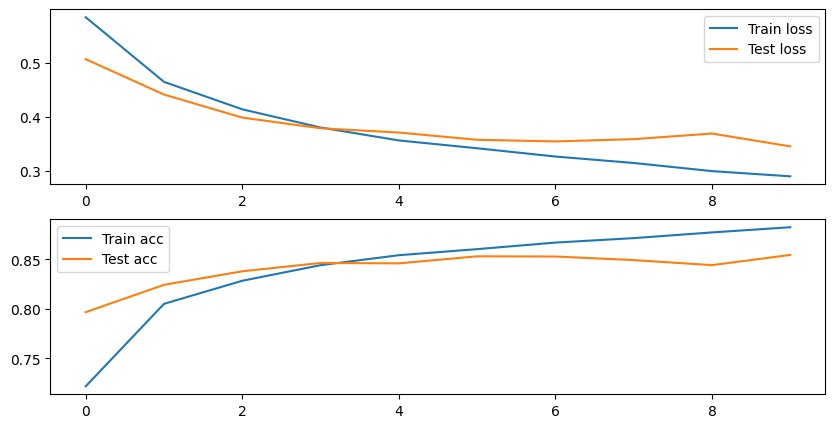

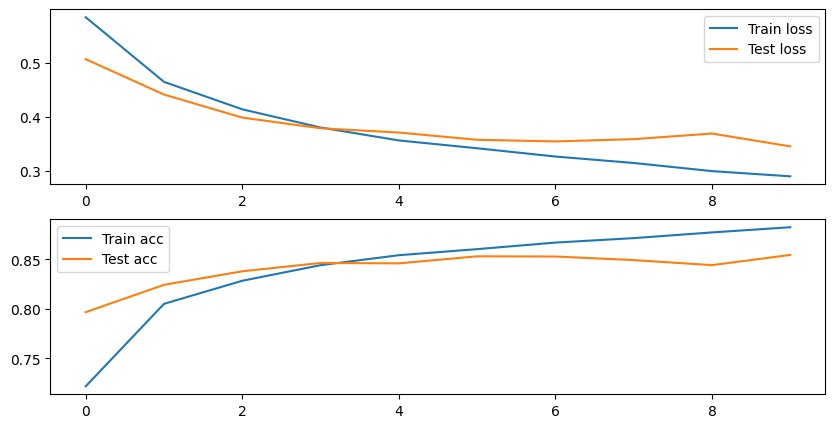

In [ ]:
nltk.flatten(np.mean(history))

In [ ]:
[np.mean(i) for i in history[0]]

In [ ]:
plt.figure(figsize=[20, 10])
plt.plot(nltk.flatten(history[1]))
# plt.plot(list(map(np.mean, history[0])))
# plt.plot(history[3][0])

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
plt.plot(train_accuracies)
plt.plot(test_accuracies)

In [ ]:
plt.plot(train_losses)
plt.plot(test_losses)

In [ ]:
print(model(torch.tensor(dataset['Padded sequences'][0]).unsqueeze(0)), dataset['Sentiment'][0])

In [ ]:
dataset['Padded sequences'][0]